<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_AnomalyDetection/blob/fix_root/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library Imports

In [1]:
try:
    import xmltodict
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install xmltodict

In [26]:
try:
    import pyod
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install pyod

     |████████████████████████████████| 112kB 4.0MB/s 
  Created wheel for pyod: filename=pyod-0.8.8-cp37-none-any.whl size=116969 sha256=5cb12e159af762d34b990ad3c941d13e2a643c1edc8c1b942d43b52106a4bd38
  Stored in directory: /root/.cache/pip/wheels/54/dd/36/a12fa930455b7c38902f2dbf737175421ad30436e47ac5b24d
Successfully built pyod


In [27]:
from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from scipy.stats import zscore 
# import statsmodels.api as sm
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pyod.models.lof import LOF
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.tsa.filters as filters
from statsmodels.tsa.filters.bk_filter import bkfilter
from scipy.stats import zscore 

import requests
import xmltodict



In [47]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

statsmodels==0.10.2
seaborn==0.11.1
scipy==1.4.1
scikit-learn==0.22.2.post1
requests==2.23.0
plotly==4.4.1
pandas==1.1.5
numpy==1.19.5
matplotlib==3.2.2


# Helper Functions

### Web Service

In [3]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  global xml, dict_of_xml, df
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values']

  #Null values are given as OrderedDictionaries with lots of text, while actual values are given as strings.  This converts all the OrderedDictionaries into actual null/none values, and converts all values that were given as strings into float numbers.
  df = pd.DataFrame(map(lambda i: float(i) if type(i) == str else None, df))

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)

  return df.iloc[:,0].astype(float)  #For some reason converting strings to floats can only be done in return.


In [4]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        additional_stations
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = pd.DataFrame(dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values'])

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)
 
  # df.iloc[:,0].astype(float)

  return pd.DataFrame(df.iloc[:,0].astype(float))  #xml returns values as strings, so need to convert them to floats.  For some reason have to do it here in return, as it doesn't work elsewhere.

In [5]:
# Function to Download Multiple Stations at a time from AWDB Web Service.  
# Not the most efficient way as it sends multiple requests.  Should change SOAP to accept multiple inserted stationtriplets in future.

def getData(stations, parameter_of_interest, begindate, enddate):
  
  try:
    data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])  
    data_singleDF.columns = [f'{j}' for j in stations]
  except ValueError:
    print('One or more of the values for an inputed date in the Air-Water Database (AWDB) is null.  Need to either select a different date or update the value using DMP in AWDB.')

  return data_singleDF

In [6]:
getData

<function __main__.getData>

### Analyses functions

In [28]:
#Other functions/attributes to add to classes:

#Descriptive stats
#Null heatmap and maybe other null exploration tools
#Other logicaltests:
    # find when values deviate significantly from the precip vs swe ratio and different ratios between stations (this is essentially fitting a regression model and finding outliers)
    # tmax > tavg > tmin
#Connect it to another webcall accessing metadata/other admin or qa/qc info. ... check out the other webcalls
#Battery check script.  Filters sites with batteries below certain voltage and which have been decreasing over a period of time.
#General sensor check script?  Looks for chaotic behavoir or the known behavoir of failing sensors.
#Distribution plots

#### Local Outlier Factor

In [99]:
def LocalOutlierFactor(df, plot_type, contamination, seasonal_differencing):

  if seasonal_differencing == True:    
    #Seasonally decompose df
    sd = seasonal_decompose(df, freq=365, extrapolate_trend='freq') #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    # bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.

    #Grab residuals(data w/o season or trend) and convert to array
    # X = pd.DataFrame(sd)
    X = sd.resid #.dropna()
    X_arr = np.array(X)
    #Scale Data
    scaler = StandardScaler()
    X_arr_scaled = scaler.fit_transform(X)
    #Create dataframe from scaled array array
    X_arr_scaled = pd.DataFrame(X_arr_scaled)
    
    #Create model and fit it to scaled data
    lof = LOF(algorithm='auto', contamination=contamination, leaf_size=30, metric='minkowski',
      metric_params=None, n_jobs=1, n_neighbors=20, p=2)
    lof.fit(X_arr_scaled)
    # LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    #   metric_params=None, n_jobs=1, n_neighbors=20, p=2)
    

    predictions = lof.predict(df)
    # df['predict_LOF'] = predictions
    #Combine anomalies with original unscaled residuals
    X['anomaly'] = predictions.tolist()
    #Combine anomalies withe the original data
    observed = sd.observed.dropna()
    df2  = pd.merge(observed, X['anomaly'], left_index=True,right_index=True)
    #Filter anomalies from the residual and original datasets
    anomalies_residuals_df = X[X['anomaly'] == 1] #Can use if plotting anomalies on residual timeseries
    anomalies2 = df2[df2['anomaly'] == 1]

    # lof_anomalies_df = df[df['predict_LOF']==1]
    #let's count the total number of outlier
    print(np.sum(predictions))
    
  
  elif seasonal_differencing == False:
    lof = LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
      metric_params=None, n_jobs=1, n_neighbors=20, p=2)
    lof.fit(df)
    # LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    #   metric_params=None, n_jobs=1, n_neighbors=20, p=2)
    
    df2 = df
    predictions = lof.predict(df2)
    df2['anomaly2'] = predictions
    anomalies2 = df2[df2['anomaly2']==1]
    
  

  # matplotlib visualization
  if plot_type == 'static':
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df2.index, df2.iloc[:,0], color='blue', label = 'Normal')
    # ax.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
    ax.scatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();
  
# plotly visualization
  elif plot_type == 'interactive':

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Normal',
      hovertext = df2.iloc[:,0],   
    ))

    fig.add_trace(go.Scatter(
      x=anomalies2.index,
      y=anomalies2.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies2.index,   
    ))

    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)

    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show()
  else:
    print('Choose either static or interactive for plot_type')

#### Isolation Forest

In [79]:
def isolationForest(df, plot_type, contamination, seasonal_differencing):

  if seasonal_differencing == True:
    
    #Seasonally decompose df
    sd = seasonal_decompose(df, freq=365, extrapolate_trend='freq') #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    # bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.

    #Grab residuals(data w/o season or trend), convert to array, scale data, convert back to DataFrame
    # X = pd.DataFrame(sd)
    X = sd.resid #.dropna()
    X_arr = np.array(X)
    scaler = StandardScaler()
    X_arr_scaled = scaler.fit_transform(X)
    X_arr_scaled = pd.DataFrame(X_arr_scaled)

    # train isolation forest
    model =  IsolationForest(n_estimators = 100, contamination = contamination, bootstrap=False)
    model.fit(X_arr_scaled)
    predictions = model.predict(X_arr_scaled)
    
    X['anomaly'] = predictions.tolist()
    observed = sd.observed.dropna()
    df2  = pd.merge(observed, X['anomaly'], left_index=True,right_index=True)

    anomalies = X[X['anomaly'] == -1] #Can use if plotting anomalies on residual timeseries
    anomalies2 = df2[df2['anomaly'] == -1]

  elif seasonal_differencing == False:
    X = np.array(df.dropna())
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(n_estimators = 100, contamination = 0.1, bootstrap=True)
    model.fit(X)

    df2 = df #Keep original data untouched
    df2['anomaly2'] = model.predict(X)
    anomalies2 = df2.loc[df2['anomaly2'] == -1]

  # matplotlib visualization
  if plot_type == 'static':
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df2.index, df2.iloc[:,0], color='blue', label = 'Normal')
    # ax.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
    ax.scatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

  # plotly visualization
  elif plot_type == 'interactive':

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Normal',
      hovertext = df2.iloc[:,0],   
    ))

    fig.add_trace(go.Scatter(
      x=anomalies2.index,
      y=anomalies2.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies2.index,   
    ))

    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)

    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show()
  else:
    print('Choose either static or interactive for plot_type')

#### Z Score

In [31]:
def zScore_plot(df, max_StDev=2.5, plot_type = 'interactive', seasonal_differencing = True):
  global zs,  X

  if seasonal_differencing == True:
    #Remove season and trend.
    sd = seasonal_decompose(df,freq=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    # bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
    X = sd.resid.dropna()
    zs = zscore(X.iloc[:,0], ddof=1, nan_policy='omit')
    X['zscore'] = zs

    observed = sd.observed.dropna()
    df2  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
    anomalies = df2[(df2['zscore'] < -max_StDev) | (df2['zscore'] > max_StDev)]

  elif seasonal_differencing == False:
    # X_arr = np.array(X)
    X = df.dropna()
    zs = zscore(X.iloc[:,0], ddof=2, nan_policy='omit')
    X['zscore'] = zs

    df2 = X
    anomalies = X[(X['zscore'] < -max_StDev) | (X['zscore'] > max_StDev)]

  # matplotlib visualization
  if plot_type == 'static':

    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df2.index, df2.iloc[:,0], color='blue', label = 'Normal')
    ax.scatter(pd.to_datetime(anomalies.index), anomalies.iloc[:,0], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

  # plotly visualization
  elif plot_type == 'interactive':

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Normal',
      hovertext = df2.iloc[:,0],   
    ))

    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      hovertext = anomalies.index,   
    ))

    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)

    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show()
  else:
    'Choose either static or interactive for plot_type'

#### Double Mass

In [32]:
def double_mass(stations, parameter, month=0):  

 #Compile and filter data with respect to inputs:
  site_list = [ORWA_Sites2[i][parameter] for i in stations] 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged
  df2.columns = [f'{i} {parameter}' for i in stations]
  
  if month == 0:
    df2 = df2
    # print(df2) 
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indices better.  When to use .dt accessor?

#Double Mass Analysis
  x=pd.DataFrame(abs(df2.iloc[:,0].diff()).cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([abs(df2.iloc[:,i].diff()).cumsum() for i in range(len(stations))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Plot the data
  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  fig = make_subplots(
      rows=1, cols=1,
      subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
      name = 'Double mass curve'
  ), 
  row=1, col=1)

  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}", row=1, col=1)
  fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{stations[1::]}</br>", row=1, col=1)

  fig.update_layout(
   height=800,
   width=1200
  )
  
  fig.show()

#### Calculate WTEQ : PREC Ratio

In [33]:
def WTEQtoPRECratio(station, begindate, enddate):

  PREC = getData(station, 'PREC',begindate, enddate)
  WTEQ = getData(station, 'WTEQ',begindate, enddate)

  #Take the last 10 measurements and average them.
  enddate_PREC_avg = sum(PREC.iloc[-10:,0])/10
  enddate_WTEQ_avg = sum(WTEQ.iloc[-10:,0])/10

  #Take the first 10 measurements and average them.
  begindate_PREC_avg = sum(PREC.iloc[:10,0])/10
  begindate_WTEQ_avg = sum(WTEQ.iloc[:10,0])/10

  #Calculate the slope
  ratio = (enddate_WTEQ_avg - begindate_WTEQ_avg)/(enddate_PREC_avg - begindate_PREC_avg)

  return ratio

In [34]:
WTEQtoPRECratio(['651:OR:SNTL'], '2018-01-01','2018-02-01')

0.7832460732984303

#### Box and Whisker Plots

In [35]:
def boxplots(df, data_pt_type):
  """
  options for data_pt_type include: 'all', 'outliers', or 'suspectedoutliers'
  """      
  # TAVG = getData(self.station, 'TAVG', self.begindate, self.enddate)
  # TMAX = getData(self.station, 'TMAX', self.begindate, self.enddate)
  # TMIN = getData(self.station, 'TMIN', self.begindate, self.enddate)
  # TOBS = getData(self.station, 'TOBS', self.begindate, self.enddate)

  # df_temp = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [TAVG, TMAX, TMIN, TOBS])
  # df_temp.columns = ['TAVG (degF)','TMAX (degF)','TMIN (degF)','TOBS (degF)']

  fig = go.Figure()
  for i in df.columns:
  #   WA = WA_Sites[WA_Sites[i] != 0].dropna()

    fig.add_trace(go.Box(y = df.loc[:,i], 
            name = i,
            boxpoints=data_pt_type, 
            # hovertext = str(df_temp[i].index),
            jitter=0.2,
            whiskerwidth=0.5                
  ))

  fig.update_layout(
          autosize=False,
          width=1200,
          height=500,
          margin=dict(l=20, r=20, t=2, b=8),
          paper_bgcolor="LightSteelBlue",
          title={
          # 'text': f'{station}',
          'y':0.98,
          'x':0.45,
          'xanchor': 'center',
          'yanchor': 'top'
  })
  fig.show()

# logicalTests and statTests Classes

### logicalTests

In [36]:
class logicalTests():
  def __init__(self, stationtriplets, begindate, enddate):
    self.stations = stationtriplets
    self.begindate = begindate
    self.enddate = enddate
    # self.SWEtoPRECratio =     #Include SWE to PREC ratio as an attribute


    WTEQ = getData(self.stations, 'WTEQ', self.begindate, self.enddate)
    PREC = getData(self.stations, 'PREC', self.begindate, self.enddate)
    SNWD = getData(self.stations, 'SNWD', self.begindate, self.enddate)

    df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [WTEQ, PREC, SNWD])
    # df = pd.merge(WTEQ, PREC, left_index=True, right_index=True).reset_index()
    df.reset_index(inplace=True)
    df.columns = ['Date', 'WTEQ (in)', 'PREC (in)', 'SNWD (in)']

    #Mask to select only data between Nov - Apr
    winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(5,10)
    df2 = df.where(winter_filter).dropna()

    #Add column specifying the water year (Oct 1 - Sep 30) of each record
    df2.reset_index(inplace=True)  #Have to reset the index so the dates become just a regular datetime object to get .dt.year to work.
    pd.to_datetime(df2['Date'])
    df2['water_year'] = pd.to_datetime(df2['Date']).dt.year.where(pd.to_datetime(df2['Date']).dt.month < 10, pd.to_datetime(df2['Date']).dt.year + 1)
    df2['water_year'] = list(map(lambda x: str(x), df2['water_year']))

    self.df2 = df2
    self.WTEQ = WTEQ
    self.PREC = PREC
    self.SNWD = SNWD

  def plots(self):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['WTEQ (in)'],
      mode='lines',
      name='WTEQ (in)',
      hovertext = self.df2['WTEQ (in)']   
    ))
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['PREC (in)'],
      mode='lines',
      name='PREC (in)',
      hovertext = self.df2['PREC (in)'],   
    ))
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['SNWD (in)'],
      mode='lines',
      name='SNWD (in)',
      hovertext = self.df2['SNWD (in)'],   
    ))
    fig.update_xaxes(title_text= 'Date')
    # fig.update_yaxes(title_text= parameter_of_interest)
    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show() 
  
  def WTEQvsPREC(self):  
    """
    Plots WTEQ vs PREC on a fixed scale line plot
    """
    fig = go.Figure()

    fig = px.line(self.df2, x="PREC (in)", y="WTEQ (in)", hover_name=self.df2['Date'], color='water_year')
    fig.update_layout(
        yaxis=dict(scaleanchor="x", scaleratio=1),
        height=800,
        width=1100)

    fig.show()

  def SWEvsSNWD(self):  
    """
    Plots SWE vs SNWD on a fixed scale line plot
    """
    fig = go.Figure()

    fig = px.line(self.df2, x="WTEQ (in)", y="SNWD (in)", hover_name=self.df2['Date'], color='water_year')
    fig.update_layout(
        yaxis=dict(scaleanchor="x", scaleratio=1),
        height=800,
        width=1100)

    fig.show()
    
  # def WTEQvsPREC_table(self, max_daily_WTEQ, max_daily_PREC):

  # #Calculate Precip increment from accumulation:
  #   self.df2['Precip Increment - Calculated (in)'] = self.df2['PREC (in)'].diff()
  #   self.df2['WTEQ - Increment (in)'] = self.df2['WTEQ (in)'].diff()


  # #Filter to retrieve potentially erroneous data
  #   df_errors = self.df2[(self.df2['Precip Increment - Calculated (in)'] <= max_daily_PREC) & (self.df2['WTEQ - Increment (in)'] >= max_daily_WTEQ)].sort_values('WTEQ - Increment (in)', ascending=False)
  #   # df_errors.to_excel('./WTEQvsPrec/'+f'{station}' + '_WTEQvsPrecipErrors.xlsx')
  #   df_errors.set_index('Date', inplace=True)
  #   df_errors.drop('index', axis=1, inplace=True)

  #   return df_errors

  # def calc_SWEvsPREC_slope():

  def PRECLessThanZero(self):
    # PREC = getData(self.stations, 'PREC', self.begindate, self.enddate)
    PrecipLessThanZero_Errors = self.PREC[self.PREC.iloc[:,0] < 0]
    return PrecipLessThanZero_Errors

### statTests

In [100]:
class statTests():
    def __init__(self, stationtriplets, begindate, enddate):
      self.station = stationtriplets
      self.begindate = begindate
      self.enddate = enddate

    def temp_boxplots(self, data_pt_type):
      """
      options for data_pt_type include: 'all', 'outliers', or 'suspectedoutliers'
      """      
      TAVG = getData(self.station, 'TAVG', self.begindate, self.enddate)
      TMAX = getData(self.station, 'TMAX', self.begindate, self.enddate)
      TMIN = getData(self.station, 'TMIN', self.begindate, self.enddate)
      TOBS = getData(self.station, 'TOBS', self.begindate, self.enddate)

      df_temp = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [TAVG, TMAX, TMIN, TOBS])
      df_temp.columns = ['TAVG (degF)','TMAX (degF)','TMIN (degF)','TOBS (degF)']

      boxplots(df_temp, data_pt_type)

    def isolationForests(self, parameter, plot_type='interactive', contamination = .02, seasonal_differencing = True):
      
      
      df = getData(self.station, parameter, self.begindate, self.enddate)

      if parameter == 'WTEQ':
        df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
        #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
        winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
        df = df.where(winter_filter).dropna()
        df.set_index('Date',inplace=True)
        # return df
      else:
        df = df

      isolationForest(df, plot_type = plot_type, contamination = contamination, seasonal_differencing = seasonal_differencing)
      
    def LocalOutlierFactor(self, parameter, plot_type = 'interactive', contamination = 0.02, seasonal_differencing=True):
    
      df = getData(self.station, parameter, self.begindate, self.enddate)

      if parameter == 'WTEQ':
        df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
        #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
        winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
        df = df.where(winter_filter).dropna()
        df.set_index('Date',inplace=True)
        # return df
      else:
        df = df
      
      lof_anomalies_df = LocalOutlierFactor(df, plot_type = plot_type, contamination = contamination, seasonal_differencing = seasonal_differencing)
      
      # fig, ax = plt.subplots(figsize=(20,12))
      # ax.plot(df[self.station]) #, df2.iloc[:,0], color='blue', label = 'Normal')
      #     # axscatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
      # #     plt.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
      # #     ax..legend()
      # ax.scatter(lof_anomalies_df.index, lof_anomalies_df[self.station], color='red')
      # plt.show();
      
      # self.lof_anomalies_df = lof_anomalies_df
      # self.df_lof = df

    def zscorePlot(self, parameter, plot_type='static', max_StDev=2.5, seasonal_differencing=True):
      df = getData(self.station, parameter, self.begindate, self.enddate)

      if parameter == 'WTEQ':
        df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
        #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
        winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
        df = df.where(winter_filter).dropna()
        df.set_index('Date',inplace=True)
        # return df
      else:
        df = df

      zScore_plot(df, max_StDev=max_StDev, plot_type=plot_type, seasonal_differencing = seasonal_differencing)


# Test Runs

In [93]:
OR302_LT = logicalTests(['464:OR:SNTL'], '01/01/2020', '05/25/2021')

In [68]:
# OR302_LT.plots()

In [69]:
# sOR302_LT.SWEvsSNWD()

In [70]:
# OR302_LT.WTEQvsPREC()

In [101]:
CA977 = statTests(['977:CA:SNTL'], '11/01/1999', '12/31/2019')

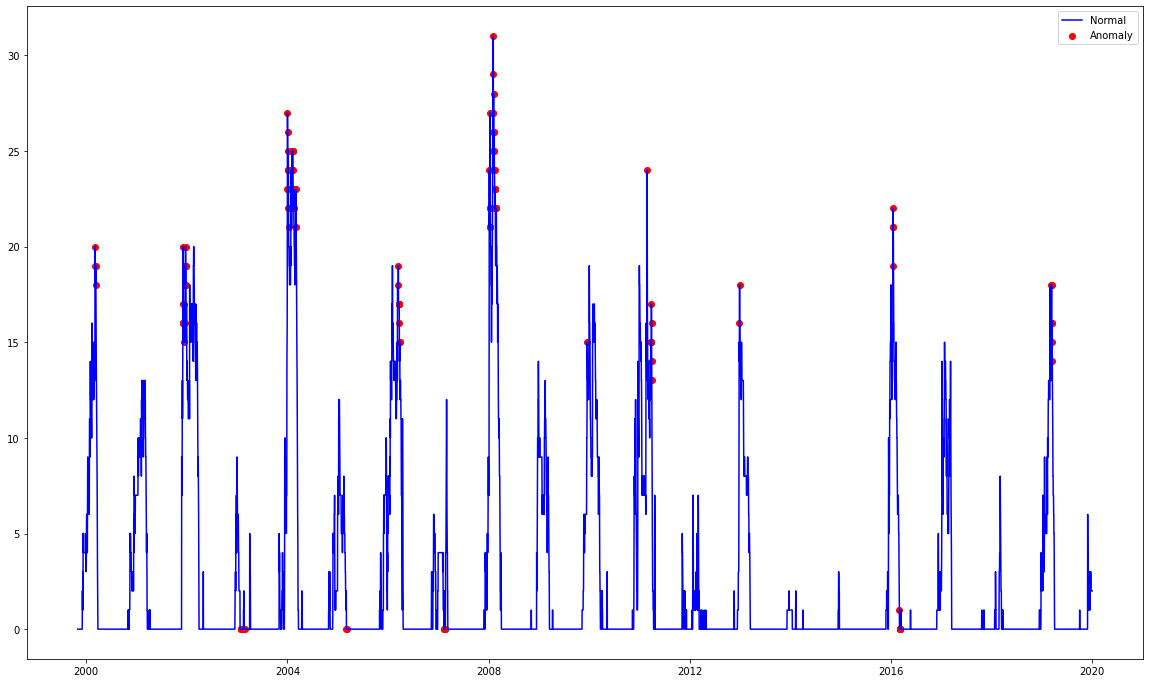

In [107]:
CA977.isolationForests('SNWD', seasonal_differencing = True, plot_type='static')

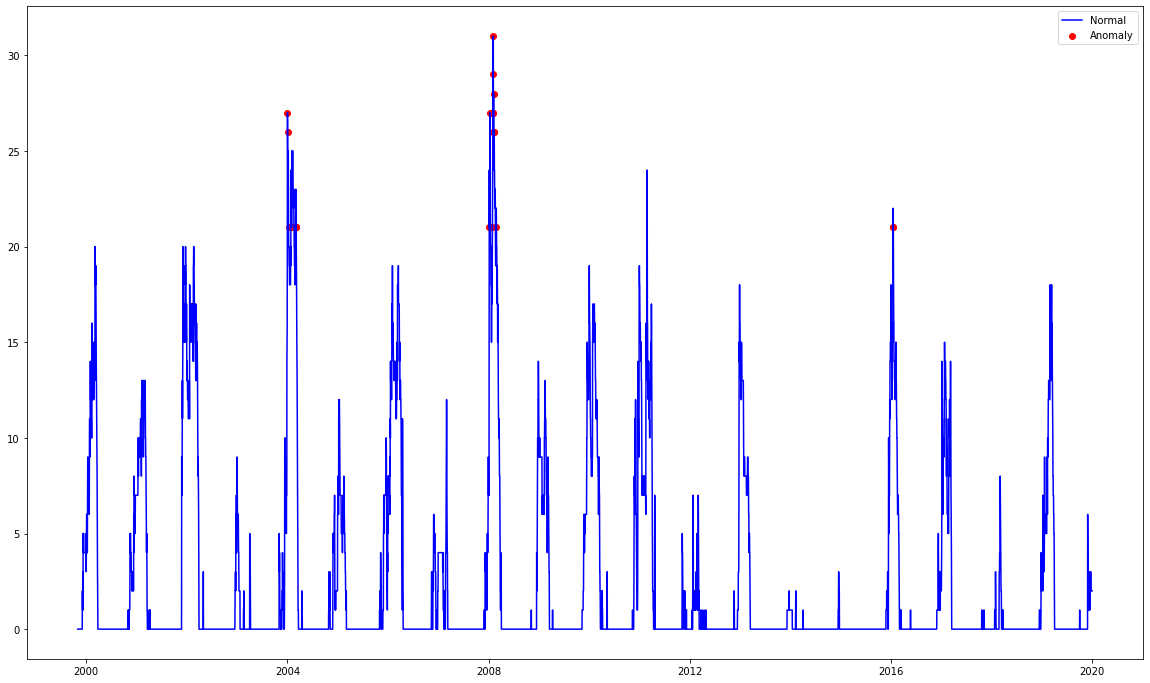

In [105]:
CA977.LocalOutlierFactor('SNWD', seasonal_differencing=False, plot_type = 'static')

In [108]:
OR302 = statTests(['302:OR:SNTL'], '04/01/2018', '11/01/2020')

In [ ]:
OR302.temp_boxplots('outliers')

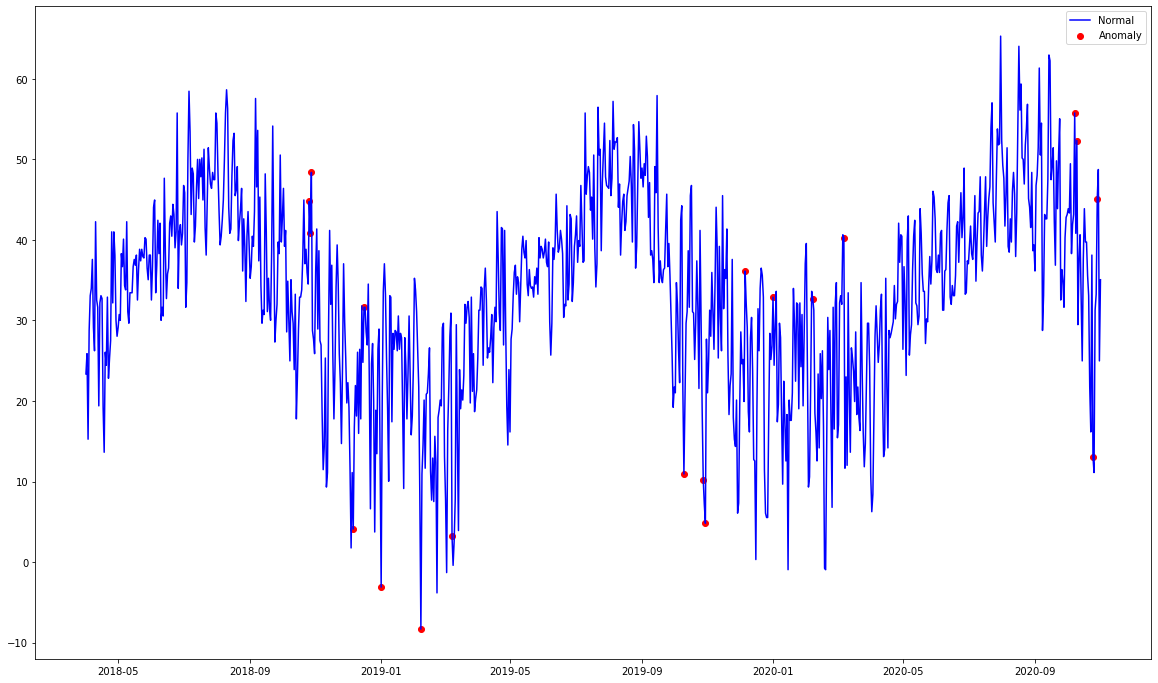

In [116]:
OR302.isolationForests('TOBS', seasonal_differencing = True, plot_type='static')

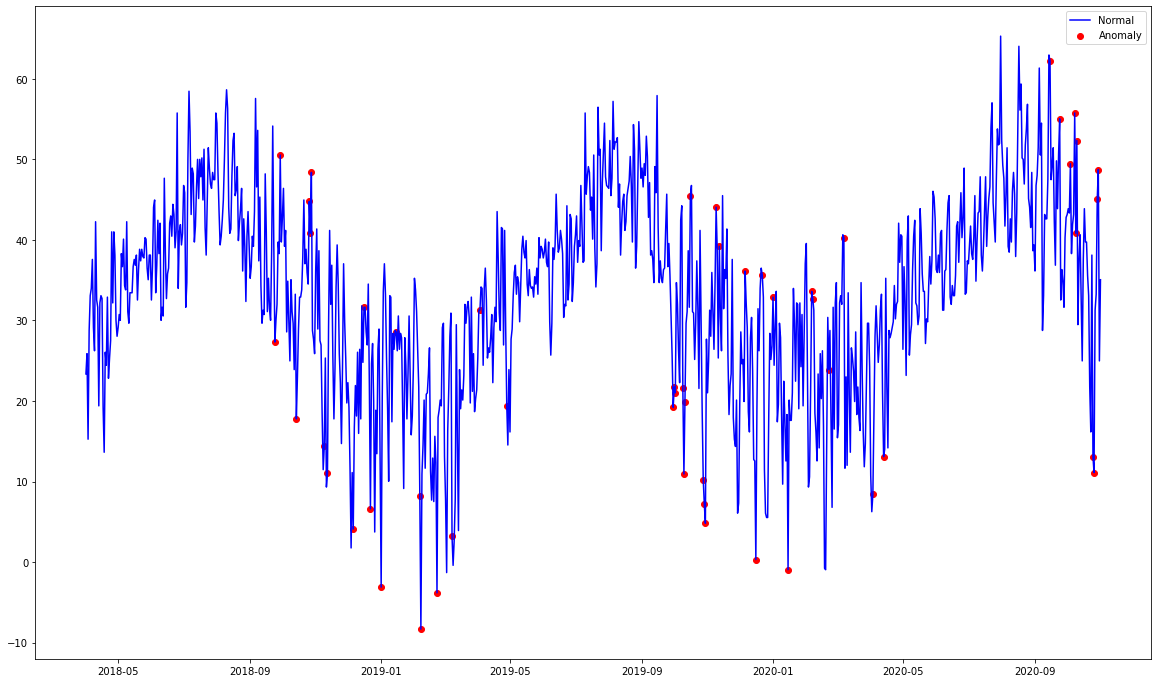

In [114]:
OR302.zscorePlot('TOBS', max_StDev=2, seasonal_differencing=True)

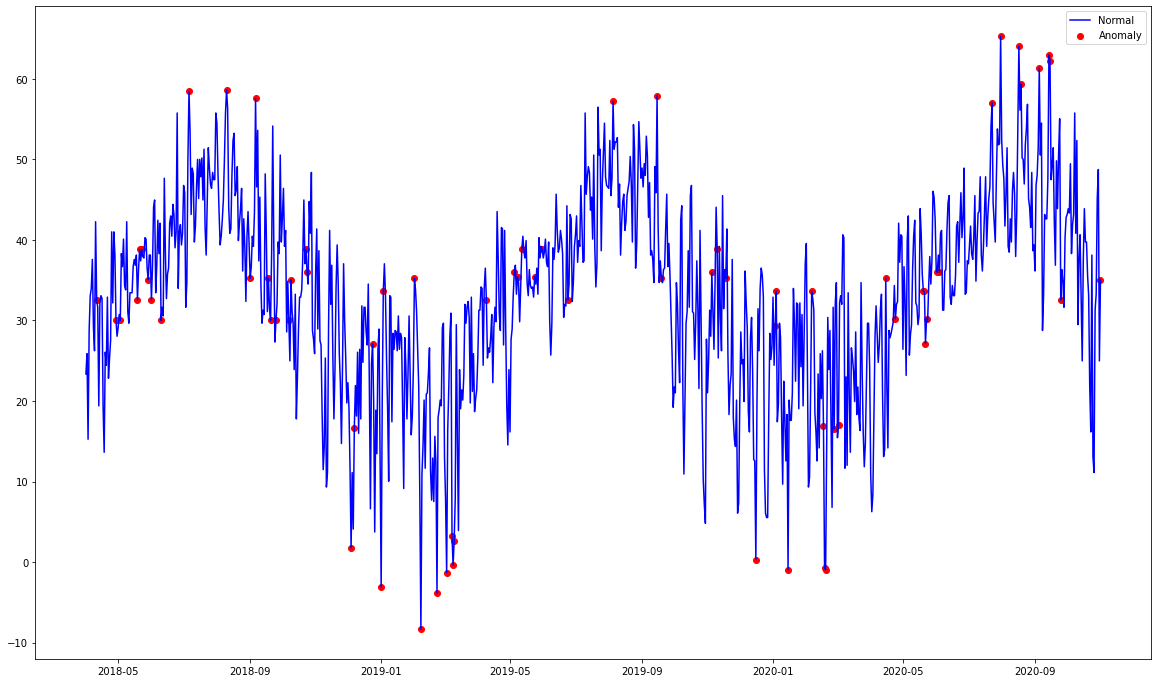

In [113]:
OR302.LocalOutlierFactor('TOBS', plot_type='static',seasonal_differencing=False)

In [ ]:
OR302.temp_boxplots(data_pt_type='outliers')

In [ ]:
# sd = seasonal_decompose(df,freq=365,extrapolate_trend='freq')

In [ ]:
# df.iloc[:,0].plot()

In [ ]:
# sd.plot();

In [ ]:
df = getData(['401:OR:SNTL'], 'TOBS', '10/01/2015', '01/30/2021')
isolationForest(df, plot_type='static',contamination = .02, seasonal_differencing=True)

ValueError: ignored

In [ ]:
df

,401:OR:SNTL
Date,
2020-10-01,62.960
2020-10-02,63.320
2020-10-03,60.620
2020-10-04,56.660
2020-10-05,58.100
...,...
2021-01-26,24.800
2021-01-27,30.740
2021-01-28,33.440


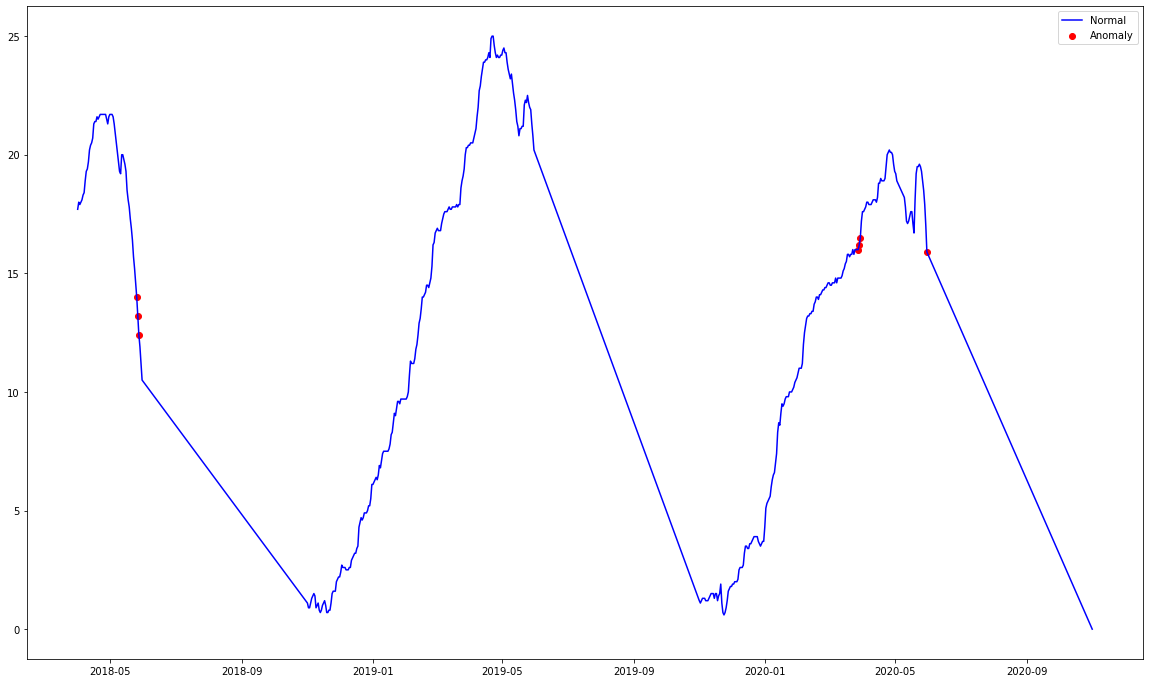

In [ ]:
OR302.isolationForests(parameter='WTEQ')

In [ ]:
stations = ['302:OR:SNTL']
begindate  = '04/01/2018'
enddate  = '04/01/2020'

for i in ['TAVG', 'TMIN']:
  df = getData(stations, i, begindate, enddate)
  zScore_plot(df.iloc[:,0], max_StDev=2)

In [ ]:
df

,zscore,302:OR:SNTL
Date,,
2018-04-02,-0.388018,30.56
2018-04-03,-1.502843,16.16
2018-04-04,-0.792143,25.34
2018-04-05,-0.165053,33.44
2018-04-06,0.057912,36.32
...,...,...
2020-03-29,-0.485566,29.30
2020-03-30,-0.374083,30.74
2020-03-31,-0.499501,29.12


In [ ]:
stations = ['302:OR:SNTL']
begindate  = '04/01/2018'
enddate  = '04/01/2020'

df = getData(stations, 'TAVG', begindate, enddate)
# TMAX = getData(stations, 'TMAX', begindate, enddate)
# TMIN = getData(stations, 'TMIN', begindate, enddate)
# TOBS = getData(stations, 'TOBS', begindate, enddate)

df_temp = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [TAVG, TMAX, TMIN, TOBS])
# df_temp.columns = ['TAVG (degF)','TMAX (degF)','TMIN (degF)','TOBS (degF)']

def zScore_plot(df_temp, degrees_of_freedom):
 
  zs = zscore(df.iloc[:,0], ddof=2, nan_policy='omit')
  df_outliers = zs[(zs['zscore'] < -3) | (zs['zscore'] > 3)].head(45)

  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x=ORWA_Sites2.index,
    y=ORWA_Sites2[station_of_interest][parameter_of_interest],
    mode='lines',
    name=station_of_interest,
    hovertext = ORWA_Sites2[station_of_interest][parameter_of_interest],   
  ))

  fig.add_trace(go.Scatter(
    x=df_outliers.index,
    y=df_outliers[station_of_interest][parameter_of_interest],
    mode='markers',
    name=station_of_interest,
    hovertext = df_outliers.index,   
  ))

  fig.update_xaxes(title_text= 'Date')
  fig.update_yaxes(title_text= parameter_of_interest)

  fig.update_layout(
    height=800,
    width=1100,
  )

  fig.show()

In [ ]:
asdf = outlierDetection(['302:OR:SNTL'],'01/01/2018', '04/01/2020')

In [ ]:
df_temp

NameError: ignored

In [ ]:
asdf.temp_boxplots('outliers')

In [ ]:
bla = logicalTests(['401:OR:SNTL'],'04/01/2021', '04/13/2021')

In [ ]:
bla.plots()

In [ ]:
bla.precipitationLessThanZero()

TypeError: ignored

In [ ]:
bla.WTEQvsPREC_table(0.5,0.2)

TypeError: ignored

In [ ]:
bla.WTEQvsPREC()

In [ ]:
bla.SWEvsSNWD()

In [ ]:
OR401 = outlierDetection(['401:OR:SNTL'],'01/01/2018', '04/01/2020')

In [ ]:
OR401.isolationForests()

NameError: ignored

In [ ]:
OR401.logicalTests.WTEQvsPREC_table(0.2,0.5)

,WTEQ (in),PREC (in),water_year,Precip Increment - Calculated (in),WTEQ - Increment (in)
Date,,,,,
2020-01-12,1.5,10.5,2020,0.4,0.9
2018-02-27,3.6,23.8,2018,0.3,0.8
2019-03-14,11.8,26.0,2019,0.4,0.7
2018-03-25,5.9,27.4,2018,0.5,0.6
2019-02-14,6.7,20.8,2019,0.4,0.6
...,...,...,...,...,...
2018-02-18,0.9,21.7,2018,0.1,0.2
2018-01-23,0.9,18.2,2018,0.1,0.2
2018-02-19,1.1,22.0,2018,0.3,0.2


In [ ]:
OR401.logicalTests.precipitationLessThanZero()

,401:OR:SNTL
Date,


In [ ]:
OR401.WTEQvsPREC_table(0.3,0.2)

,WTEQ (in),PREC (in),water_year,Precip Increment - Calculated (in),WTEQ - Increment (in)
Date,,,,,
2014-12-29,0.8,18.9,2015,0.2,0.6
2020-02-17,5.0,20.0,2020,0.2,0.5
2014-02-22,7.0,20.7,2014,0.2,0.5
2018-04-14,4.9,30.2,2018,0.2,0.5
2014-02-21,6.5,20.5,2014,0.2,0.4
2017-03-02,15.3,32.3,2017,0.2,0.4
2015-01-06,2.7,20.4,2015,0.2,0.4
2017-11-19,1.3,8.8,2018,0.1,0.4
2019-02-18,7.6,21.6,2019,0.1,0.4
